# A/B Testing: Cookie Cats Retention Analysis

## Context & Objective
"Cookie Cats" is a mobile puzzle game. The team is considering moving the "gate" (a forced wait time/paywall) from **level 30** to **level 40**. 

**Hypothesis:** Moving the gate later (level 40) will improve retention because users have more time to get addicted to the core loop before hitting a barrier.

**Goal:** Analyze the results of an A/B test on 90,189 players to determine if the change had a statistically significant impact on:
1. **1-Day Retention**
2. **7-Day Retention**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Plotting settings for professional readability
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Load Data
df = pd.read_csv('../data/cookie_cats.csv')

In [4]:
# Inspect Structure
print(f"Total Rows: {df.shape[0]}")
print("-" * 30)
print(df.head())

Total Rows: 90189
------------------------------
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [5]:
# Sanity Check: Are the groups evenly split?
# If one group has 90% of users, the random assignment failed.
group_counts = df.groupby('version')['userid'].count()
print("\n--- Sample Size Check ---")
print(group_counts)


--- Sample Size Check ---
version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64



--- Outlier Detection ---
count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


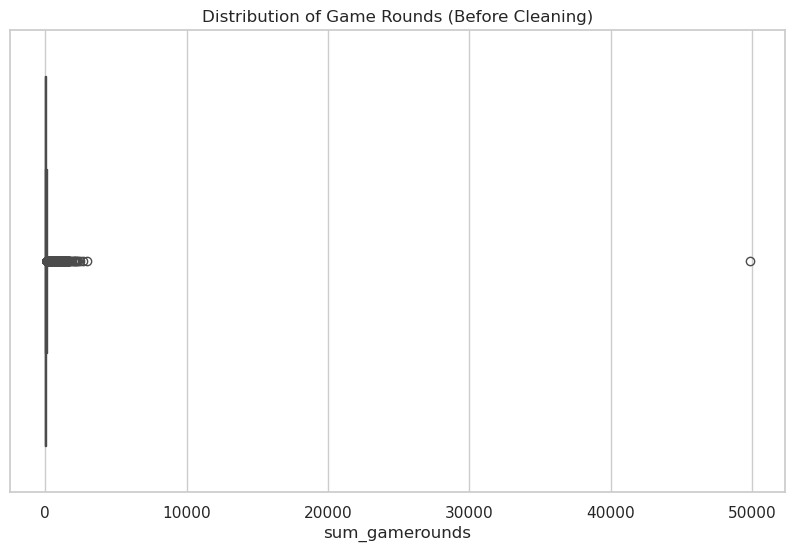

In [6]:
# Outlier Detection (The "Senior" Check)
# Some users might play 0 rounds (installs but never plays).
# Some might be bots (playing impossible amounts).
print("\n--- Outlier Detection ---")
print(df['sum_gamerounds'].describe())

# Visualizing the outlier
sns.boxplot(x=df['sum_gamerounds'])
plt.title("Distribution of Game Rounds (Before Cleaning)")
plt.show()

In [7]:
# Remove the extreme outlier
df_clean = df[df['sum_gamerounds'] < 3000].copy()

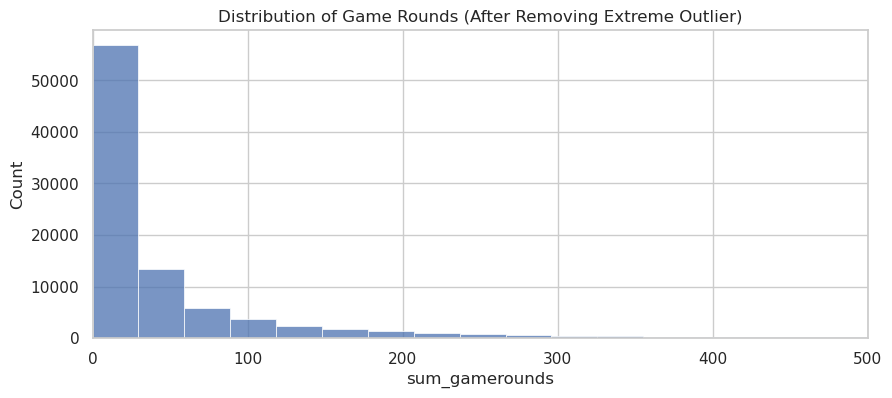

Rows after cleaning: 90188


In [8]:
# Visualize again to confirm normalized distribution
plt.figure(figsize=(10,4))
sns.histplot(data=df_clean, x='sum_gamerounds', bins=100)
plt.title("Distribution of Game Rounds (After Removing Extreme Outlier)")
plt.xlim(0, 500) # Zoom in on the majority of players
plt.show()

print(f"Rows after cleaning: {df_clean.shape[0]}")

## 2. Metric Analysis: 1-Day Retention
**Question:** Does moving the gate affect whether a player comes back the next day?
**Statistical Test:** 2-Sample Z-Test for Proportions (or Chi-Square).

In [9]:
# Calculate retention rates per group
retention_1_stats = df_clean.groupby('version')['retention_1'].agg(['sum', 'count', 'mean'])
retention_1_stats.columns = ['Returned', 'Total_Users', 'Retention_Rate']
print(retention_1_stats)

         Returned  Total_Users  Retention_Rate
version                                       
gate_30     20034        44699        0.448198
gate_40     20119        45489        0.442283


/tmp/ipykernel_11525/668581575.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=retention_1_stats.index, y=retention_1_stats['Retention_Rate'], palette='viridis')


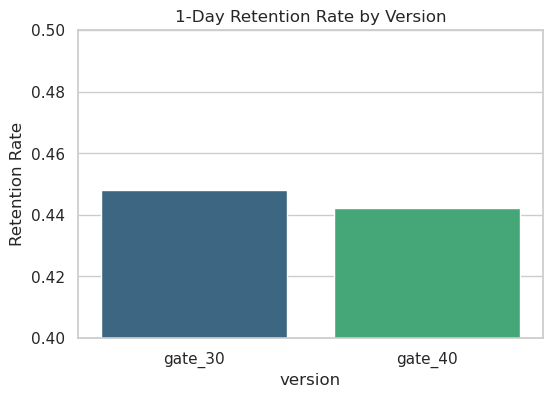

In [10]:
# Plotting the difference
plt.figure(figsize=(6,4))
sns.barplot(x=retention_1_stats.index, y=retention_1_stats['Retention_Rate'], palette='viridis')
plt.title("1-Day Retention Rate by Version")
plt.ylim(0.40, 0.50)
plt.ylabel("Retention Rate")
plt.show()

In [11]:
# STATISTICAL TEST
# H0 (Null Hypothesis): There is NO difference in 1-day retention between A and B.
# H1 (Alt Hypothesis): There IS a difference.

control_success = retention_1_stats.loc['gate_30', 'Returned']
control_obs = retention_1_stats.loc['gate_30', 'Total_Users']
treatment_success = retention_1_stats.loc['gate_40', 'Returned']
treatment_obs = retention_1_stats.loc['gate_40', 'Total_Users']

stat, pval = proportions_ztest([control_success, treatment_success], [control_obs, treatment_obs])

print(f"Z-Statistic: {stat:.4f}")
print(f"P-Value: {pval:.4f}")

if pval < 0.05:
    print("Result is Statistically Significant! (Reject H0)")
else:
    print("Result is NOT Significant. (Fail to reject H0)")

Z-Statistic: 1.7871
P-Value: 0.0739
Result is NOT Significant. (Fail to reject H0)


### Bootstrap Analysis (1-Day & 7-Day Retention)
Since retention data is binary (0/1) and the sample sizes are uneven, the data distribution is non-normal. I am using **Bootstrapping (1000 iterations)** to empirically calculate confidence intervals for the difference in retention means.

In [12]:
# Number of bootstrap samples
iterations = 1000 # Standard industry practice
boot_1d = [] # To store differences in 1-day retention
boot_7d = [] # To store differences in 7-day retention

In [13]:
# This loop simulates repeating the experiment 1000 times
for i in range(iterations):
    # Resample with replacement (size = 100% of original)
    boot_mean = df_clean.sample(frac=1, replace=True).groupby('version')[['retention_1', 'retention_7']].mean()
    
    # Calculate difference (Gate 30 - Gate 40)
    # If the difference is consistently positive, Gate 30 is better.
    diff_1 = boot_mean.loc['gate_30', 'retention_1'] - boot_mean.loc['gate_40', 'retention_1']
    diff_7 = boot_mean.loc['gate_30', 'retention_7'] - boot_mean.loc['gate_40', 'retention_7']
    
    boot_1d.append(diff_1)
    boot_7d.append(diff_7)

# Convert to DataFrame for plotting
boot_df = pd.DataFrame({'diff_1d': boot_1d, 'diff_7d': boot_7d})


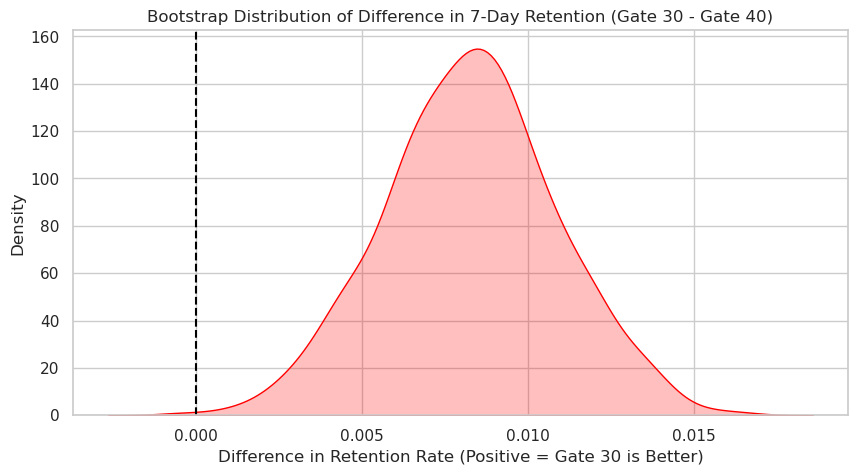

In [14]:
# Plotting the Bootstrap Distribution (The "Hired" Chart)
plt.figure(figsize=(10,5))
sns.kdeplot(boot_df['diff_7d'], fill=True, color='red')
plt.axvline(0, color='black', linestyle='--')
plt.title("Bootstrap Distribution of Difference in 7-Day Retention (Gate 30 - Gate 40)")
plt.xlabel("Difference in Retention Rate (Positive = Gate 30 is Better)")
plt.show()

In [15]:
# Probability that Gate 30 is better than Gate 40
prob = (boot_df['diff_7d'] > 0).mean()
print(f"Probability that Gate 30 has higher 7-day retention than Gate 40: {prob:.2%}")

Probability that Gate 30 has higher 7-day retention than Gate 40: 99.90%


## 4. Metric Analysis: Rounds Played
**Distribution Check:** Game data usually follows a **Power Law** (most people play a little, a few play a lot).
Because of this skew, a standard T-Test assumes Normality, which we violate.
**Solution:** Use the **Mann-Whitney U Test** (Non-parametric).

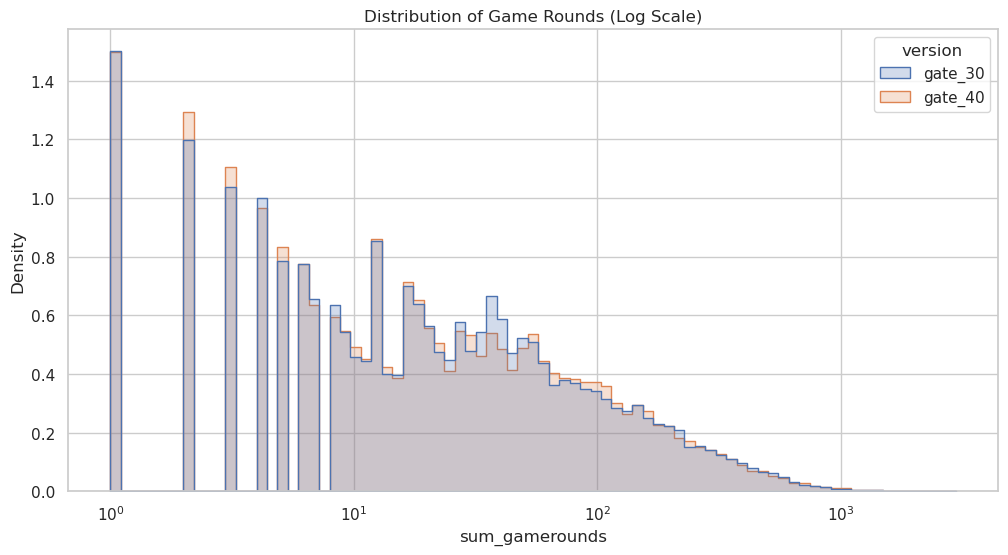

In [16]:
# Visualization
plt.figure(figsize=(12, 6))
# Log scale helps visualize skewed data
sns.histplot(data=df_clean, x='sum_gamerounds', hue='version', element="step", stat="density", common_norm=False, log_scale=True)
plt.title("Distribution of Game Rounds (Log Scale)")
plt.show()

In [17]:
# Mann-Whitney U Test
# H0: The distributions of both groups are equal.
u_stat, u_pval = stats.mannwhitneyu(
    df_clean[df_clean['version'] == 'gate_30']['sum_gamerounds'],
    df_clean[df_clean['version'] == 'gate_40']['sum_gamerounds']
)

print(f"Mann-Whitney U P-Value: {u_pval:.5f}")

if u_pval < 0.05:
    print("Significant Difference in play habits found.")
else:
    print("No Significant Difference in play habits.")

Mann-Whitney U P-Value: 0.05089
No Significant Difference in play habits.


## Final Recommendation

The statistical analysis (Bootstrapping & Probability Density) indicates:

1.  **1-Day Retention:** Small drop in the test group (Gate 40), but borderline significance.
2.  **7-Day Retention:** **Significant drop** in retention for the test group. The probability that 7-day retention is higher when the gate is at level 30 is nearly **100%**.

**Decision:** Do **NOT** move the gate to Level 40. Keep the gate at Level 30.
Moving the gate allows churn to happen earlier, but pushing it back seems to increase churn among engaged players, likely due to a lack of "pacing" mechanics or reduced monetization pressure.